In [1]:
# CS 763 - Lab 8 (GANs) Part-A
#!/usr/bin/env python
# coding: utf-8


from tqdm import tqdm
import time
import sys
import os
import PIL
from torch.nn import functional as F
from torch import nn, optim
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import torchvision
import random
import torch
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

# Check for GPU specs
get_ipython().system('nvidia-smi')

# device set to cuda if GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Sun Apr 18 19:04:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:03:00.0 Off |                  N/A |
| 41%   47C    P2    65W / 280W |  16975MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:81:00.0 Off |                  N/A |
| 23%   

Lenth of Trainset = 60000
Lenth of Testset = 10000
Dimensions of each image = (28,28)


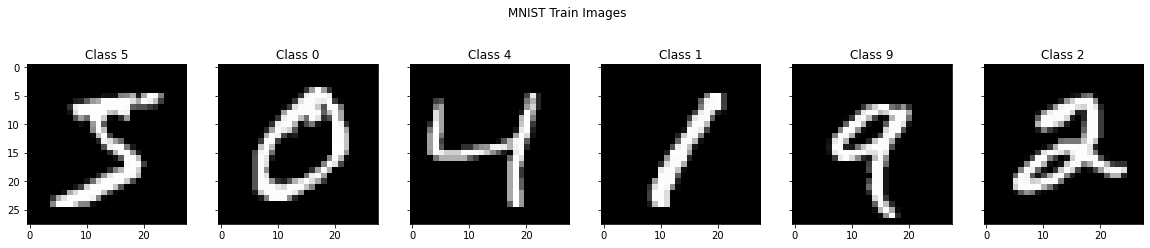

In [2]:
# Function to fix the seed for randomisation

def fix_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


fix_seed(763)


# We will use the MNIST dataset for Part A of the lab.

# define transformations to be applied on the input images
# Input images from the dataset are PIL objects, hence we first convert them to Tensors, then we normalise them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

trainset = torchvision.datasets.MNIST(
    './data', download=True, train=True, transform=transform)
testset = torchvision.datasets.MNIST(
    './data', download=True, train=False, transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, num_workers=2, shuffle=True)
testloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, num_workers=2)

# Visualising the dataset
print('Lenth of Trainset = {}'.format(len(trainset)))
print('Lenth of Testset = {}'.format(len(testset)))
print('Dimensions of each image = ({},{})'.format(
    trainset[0][0].shape[1], trainset[0][0].shape[2]))
fig, axs = plt.subplots(1, 6, sharey=True, figsize=(20, 4))
for i in range(6):
    axs[i].imshow(trainset[i][0].squeeze(), cmap='gray')
    axs[i].set_title('Class {}'.format(trainset[i][1]))
plt.suptitle('MNIST Train Images')
plt.show()

In [3]:
# Generator and Discriminator Architecures

# The generator takes a noise vector of size (B,100), where B is the batch size and produces a 28x28 image
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ## TODO ##
        self.network = nn.Sequential(
          nn.ConvTranspose2d(100, 32*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(32*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(32*4, 32*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(32*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(32*2, 32, 4, 2, 1, bias=False),
          nn.BatchNorm2d(32),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
          nn.Tanh()
      )
        ## TODO ##

    # forward pass
    def forward(self, x):
        ## TODO ##
        output = self.network(x)
        return output
        ## TODO ##


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ## TODO ##
        self.network = nn.Sequential(
                nn.Conv2d(1, 32, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(32, 32 * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(32 * 2),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(32 * 2, 32 * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(32 * 4),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(32 * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
        ## TODO ##

    # forward pass
    def forward(self, x):
        ## TODO ##
        output = self.network(x)
        return output.view(-1, 1).squeeze(1)
        ## TODO ##

In [5]:
# Create the models
    
G = Generator().to(device)
D = Discriminator().to(device)

# Create a BCELoss object
## TODO ##
criterion = torch.nn.BCELoss()
## TODO ##

# Define two separate optimizers for generator and discriminator
## TODO ##
lr = 1e-4
optimizer_g = torch.optim.Adam(G.parameters(),lr=lr)
optimizer_d = torch.optim.Adam(D.parameters(),lr=lr)
## TODO ##


# Train Function
# returns the total loss for the epoch
def train(epoch):
    loss_acc_g = 0
    loss_acc_d = 0
    loss_acc = 0

    for i, (images, _) in tqdm(enumerate(trainloader), desc="Training for epoch {}".format(epoch), total=len(trainloader)):
        optimizer_d.zero_grad()
        # Discriminator training on real images
        ## TODO ##
        prediction_on_real = D(images.to(device))
        loss_real = criterion(prediction_on_real,torch.ones(prediction_on_real.shape[0]).to(device))
        ## TODO ##
        # Discriminator training on fake images
        ## TODO ##
        fake_samples = G(torch.empty(images.shape[0],100,1,1).normal_().to(device))
        prediction_on_fake = D(fake_samples.detach())  # don't forget to use detach() here
        loss_fake = criterion(prediction_on_fake,torch.zeros(prediction_on_fake.shape[0]).to(device))
        ## TODO ##
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # Generator training
        optimizer_g.zero_grad()
        ## TODO ##
        fake_samples = G(torch.empty(images.shape[0],100,1,1).normal_().to(device))
        prediction_on_fake = D(fake_samples)
        loss_g = criterion(prediction_on_fake,torch.ones(prediction_on_fake.shape[0]).to(device))
        ## TODO ##
        loss_g.backward()
        optimizer_g.step()

        loss_acc += (loss_g + loss_d).item()
        loss_acc_g += loss_g.item()
        loss_acc_d += loss_d.item()

    return loss_acc/i, loss_acc_g/i, loss_acc_d/i

Training for epoch 11: 100%|██████████| 469/469 [00:06<00:00, 67.52it/s]


loss_g = 2.2626506003559146, loss_d = 0.395518031098649



Training for epoch 12: 100%|██████████| 469/469 [00:07<00:00, 61.90it/s]


loss_g = 2.3925690834338846, loss_d = 0.41499011291780025



Training for epoch 13: 100%|██████████| 469/469 [00:06<00:00, 68.95it/s]


loss_g = 2.245841706665153, loss_d = 0.4420786121398465



Training for epoch 14: 100%|██████████| 469/469 [00:06<00:00, 68.34it/s]


loss_g = 2.204765967451609, loss_d = 0.45061732029430884



Training for epoch 15: 100%|██████████| 469/469 [00:07<00:00, 66.29it/s]


loss_g = 2.1579209820837035, loss_d = 0.4517282830216946



Training for epoch 16: 100%|██████████| 469/469 [00:07<00:00, 62.77it/s]


loss_g = 2.197556102887178, loss_d = 0.48085797616304493



Training for epoch 17: 100%|██████████| 469/469 [00:07<00:00, 64.33it/s]


loss_g = 2.1463652939623237, loss_d = 0.4765850706423959



Training for epoch 18: 100%|██████████| 469/469 [00:07<00:00, 66.33it/s]


loss_g = 2.1297757347934265, loss_d = 0.4931157581253439



Training for epoch 19: 100%|██████████| 469/469 [00:07<00:00, 63.52it/s]


loss_g = 2.0955878246543755, loss_d = 0.4788924472836348



Training for epoch 20: 100%|██████████| 469/469 [00:07<00:00, 63.55it/s]


loss_g = 2.1317059867657147, loss_d = 0.4964427199119177



Training for epoch 21: 100%|██████████| 469/469 [00:06<00:00, 67.12it/s]


loss_g = 2.145607569788256, loss_d = 0.4970001710148958



Training for epoch 22: 100%|██████████| 469/469 [00:07<00:00, 63.44it/s]


loss_g = 2.158621941621487, loss_d = 0.4901312349889523



Training for epoch 23: 100%|██████████| 469/469 [00:07<00:00, 64.41it/s]


loss_g = 2.1014373931619854, loss_d = 0.5163114726479746



Training for epoch 24: 100%|██████████| 469/469 [00:07<00:00, 64.15it/s]


loss_g = 2.0955811156931086, loss_d = 0.5056669286683074



Training for epoch 25: 100%|██████████| 469/469 [00:07<00:00, 65.02it/s]


loss_g = 2.151016551077875, loss_d = 0.5114270682390939



Training for epoch 26: 100%|██████████| 469/469 [00:06<00:00, 67.94it/s]


loss_g = 2.133574623073268, loss_d = 0.5380587670792881



Training for epoch 27: 100%|██████████| 469/469 [00:07<00:00, 62.36it/s]


loss_g = 2.07213376628028, loss_d = 0.5198005905263444



Training for epoch 28: 100%|██████████| 469/469 [00:07<00:00, 65.62it/s]


loss_g = 2.065627920321929, loss_d = 0.5223452733495296



Training for epoch 29: 100%|██████████| 469/469 [00:07<00:00, 66.36it/s]


loss_g = 2.113752112047285, loss_d = 0.5213593139480321



Training for epoch 30: 100%|██████████| 469/469 [00:06<00:00, 67.88it/s]


loss_g = 2.0923410822183657, loss_d = 0.5450197536275427



Training for epoch 31: 100%|██████████| 469/469 [00:07<00:00, 65.77it/s]


loss_g = 2.109168264473605, loss_d = 0.5403608644110525



Training for epoch 32: 100%|██████████| 469/469 [00:07<00:00, 65.65it/s]


loss_g = 2.0450342203307357, loss_d = 0.5380903008019823



Training for epoch 33: 100%|██████████| 469/469 [00:07<00:00, 65.38it/s]


loss_g = 2.0654479621822, loss_d = 0.5177506417609178



Training for epoch 34: 100%|██████████| 469/469 [00:07<00:00, 64.57it/s]


loss_g = 2.0452885212551832, loss_d = 0.526726729531064



Training for epoch 35: 100%|██████████| 469/469 [00:07<00:00, 65.00it/s]


loss_g = 2.095603975602704, loss_d = 0.5150525293543807



Training for epoch 36: 100%|██████████| 469/469 [00:07<00:00, 63.95it/s]


loss_g = 2.090113720832727, loss_d = 0.5179671547097019



Training for epoch 37: 100%|██████████| 469/469 [00:07<00:00, 64.75it/s]


loss_g = 2.0665904517866607, loss_d = 0.5192372291070274



Training for epoch 38: 100%|██████████| 469/469 [00:06<00:00, 67.57it/s]


loss_g = 2.091976159530827, loss_d = 0.520338609878324



Training for epoch 39: 100%|██████████| 469/469 [00:07<00:00, 64.32it/s]


loss_g = 2.103331313938157, loss_d = 0.5344589848039497



Training for epoch 40: 100%|██████████| 469/469 [00:06<00:00, 67.05it/s]


loss_g = 2.066174950227778, loss_d = 0.5404265457684667



Training for epoch 41: 100%|██████████| 469/469 [00:06<00:00, 68.04it/s]


loss_g = 2.049889652010722, loss_d = 0.5144038049456401



Training for epoch 42: 100%|██████████| 469/469 [00:07<00:00, 66.71it/s]


loss_g = 2.081078376907569, loss_d = 0.49686129056872463



Training for epoch 43: 100%|██████████| 469/469 [00:07<00:00, 64.88it/s]


loss_g = 2.110674128573165, loss_d = 0.4930784791453272



Training for epoch 44: 100%|██████████| 469/469 [00:07<00:00, 65.63it/s]


loss_g = 2.141582755578889, loss_d = 0.5167845845158793



Training for epoch 45: 100%|██████████| 469/469 [00:07<00:00, 65.13it/s]


loss_g = 2.108098312575593, loss_d = 0.5164653723820661



Training for epoch 46: 100%|██████████| 469/469 [00:07<00:00, 62.56it/s]


loss_g = 2.084258478294071, loss_d = 0.5387172217234077



Training for epoch 47: 100%|██████████| 469/469 [00:07<00:00, 64.01it/s]


loss_g = 2.1273667614938865, loss_d = 0.49950492146432907



Training for epoch 48: 100%|██████████| 469/469 [00:07<00:00, 63.53it/s]


loss_g = 2.1429967169578257, loss_d = 0.5048190898174404



Training for epoch 49: 100%|██████████| 469/469 [00:07<00:00, 65.89it/s]


loss_g = 2.1043266261744704, loss_d = 0.5085089947296004



Training for epoch 50: 100%|██████████| 469/469 [00:07<00:00, 65.02it/s]


loss_g = 2.1629680235925903, loss_d = 0.5188691712852217



Training for epoch 51: 100%|██████████| 469/469 [00:07<00:00, 64.99it/s]


loss_g = 2.1435845657291575, loss_d = 0.48730037125766784



Training for epoch 52: 100%|██████████| 469/469 [00:07<00:00, 63.45it/s]


loss_g = 2.1984392694937878, loss_d = 0.4867779296050724



Training for epoch 53: 100%|██████████| 469/469 [00:07<00:00, 66.39it/s]


loss_g = 2.100533331179211, loss_d = 0.5095630930338659



Training for epoch 54: 100%|██████████| 469/469 [00:07<00:00, 66.01it/s]


loss_g = 2.153444124465315, loss_d = 0.49934885695449305



Training for epoch 55: 100%|██████████| 469/469 [00:07<00:00, 63.39it/s]


loss_g = 2.2511944549205976, loss_d = 0.4702193374053026



Training for epoch 56: 100%|██████████| 469/469 [00:07<00:00, 65.73it/s]


loss_g = 2.1884126398298474, loss_d = 0.4790998333030277



Training for epoch 57: 100%|██████████| 469/469 [00:07<00:00, 64.42it/s]


loss_g = 2.1654721171173277, loss_d = 0.4868724076793744



Training for epoch 58: 100%|██████████| 469/469 [00:07<00:00, 62.19it/s]


loss_g = 2.198834620225124, loss_d = 0.48426013060996675



Training for epoch 59: 100%|██████████| 469/469 [00:07<00:00, 65.16it/s]


loss_g = 2.1765316680201097, loss_d = 0.4695598063751673



Training for epoch 60: 100%|██████████| 469/469 [00:07<00:00, 63.88it/s]


loss_g = 2.237348092799513, loss_d = 0.4587225217021938



Training for epoch 61: 100%|██████████| 469/469 [00:07<00:00, 63.35it/s]


loss_g = 2.1976351260374756, loss_d = 0.48754508812458086



Training for epoch 62: 100%|██████████| 469/469 [00:07<00:00, 61.89it/s]


loss_g = 2.2168286133271, loss_d = 0.4742280922384344



Training for epoch 63: 100%|██████████| 469/469 [00:06<00:00, 69.04it/s]


loss_g = 2.2013281343074946, loss_d = 0.44238631669272727



Training for epoch 64: 100%|██████████| 469/469 [00:06<00:00, 67.22it/s]


loss_g = 2.276000432861157, loss_d = 0.4554547385718578



Training for epoch 65: 100%|██████████| 469/469 [00:07<00:00, 61.36it/s]


loss_g = 2.226623758418947, loss_d = 0.47428887334262204



Training for epoch 66: 100%|██████████| 469/469 [00:07<00:00, 66.98it/s]


loss_g = 2.2358018609448376, loss_d = 0.47640295358549833



Training for epoch 67: 100%|██████████| 469/469 [00:07<00:00, 63.88it/s]


loss_g = 2.274055127404694, loss_d = 0.4713723888764015



Training for epoch 68: 100%|██████████| 469/469 [00:07<00:00, 65.86it/s]


loss_g = 2.216546710102986, loss_d = 0.46444284581603146



Training for epoch 69: 100%|██████████| 469/469 [00:07<00:00, 65.41it/s]


loss_g = 2.2485900772178273, loss_d = 0.44411161239457947



Training for epoch 70: 100%|██████████| 469/469 [00:07<00:00, 65.54it/s]


loss_g = 2.2972894919733715, loss_d = 0.44302749544636816



Training for epoch 71: 100%|██████████| 469/469 [00:07<00:00, 65.10it/s]


loss_g = 2.337287432426571, loss_d = 0.4554082634102585



Training for epoch 72: 100%|██████████| 469/469 [00:07<00:00, 60.10it/s]


loss_g = 2.3432909350874076, loss_d = 0.443475465521089



Training for epoch 73: 100%|██████████| 469/469 [00:07<00:00, 63.11it/s]


loss_g = 2.2903284644469237, loss_d = 0.44603145501425123



Training for epoch 74: 100%|██████████| 469/469 [00:07<00:00, 66.39it/s]


loss_g = 2.3312872477576265, loss_d = 0.4230844201122084



Training for epoch 75: 100%|██████████| 469/469 [00:07<00:00, 66.12it/s]


loss_g = 2.3414379360838833, loss_d = 0.4323929198659383



Training for epoch 76: 100%|██████████| 469/469 [00:06<00:00, 67.71it/s]


loss_g = 2.3654876909194846, loss_d = 0.42451389783468



Training for epoch 77: 100%|██████████| 469/469 [00:07<00:00, 61.08it/s]


loss_g = 2.3470510583148045, loss_d = 0.4435599900336347



Training for epoch 78: 100%|██████████| 469/469 [00:07<00:00, 62.19it/s]


loss_g = 2.3464118983501043, loss_d = 0.4267284958981551



Training for epoch 79: 100%|██████████| 469/469 [00:07<00:00, 65.24it/s]


loss_g = 2.423361529206109, loss_d = 0.4514549739467792



Training for epoch 80: 100%|██████████| 469/469 [00:07<00:00, 64.78it/s]


loss_g = 2.446577601071097, loss_d = 0.44537973193786085



Training for epoch 81: 100%|██████████| 469/469 [00:07<00:00, 64.88it/s]


loss_g = 2.399081882248577, loss_d = 0.4057198570261144



Training for epoch 82: 100%|██████████| 469/469 [00:06<00:00, 67.82it/s]


loss_g = 2.4231680625269556, loss_d = 0.40770598052021784



Training for epoch 83: 100%|██████████| 469/469 [00:07<00:00, 64.92it/s]


loss_g = 2.4301117507056293, loss_d = 0.41300792651426077



Training for epoch 84: 100%|██████████| 469/469 [00:07<00:00, 64.41it/s]


loss_g = 2.4474015564490585, loss_d = 0.42246777003901637



Training for epoch 85: 100%|██████████| 469/469 [00:07<00:00, 65.38it/s]


loss_g = 2.4701434103851643, loss_d = 0.421083421438423



Training for epoch 86: 100%|██████████| 469/469 [00:06<00:00, 67.38it/s]


loss_g = 2.408091699338367, loss_d = 0.4291315346192091



Training for epoch 87: 100%|██████████| 469/469 [00:07<00:00, 64.93it/s]


loss_g = 2.4294688103035984, loss_d = 0.42252192846857584



Training for epoch 88: 100%|██████████| 469/469 [00:07<00:00, 65.86it/s]


loss_g = 2.4666730259728227, loss_d = 0.40238446516231596



Training for epoch 89: 100%|██████████| 469/469 [00:06<00:00, 68.24it/s]


loss_g = 2.4713928098352547, loss_d = 0.4212694646328942



Training for epoch 90: 100%|██████████| 469/469 [00:07<00:00, 65.08it/s]


loss_g = 2.431954880937552, loss_d = 0.38572176650930673



Training for epoch 91: 100%|██████████| 469/469 [00:06<00:00, 67.42it/s]


loss_g = 2.516999165726523, loss_d = 0.39418331661030775



Training for epoch 92: 100%|██████████| 469/469 [00:07<00:00, 63.33it/s]


loss_g = 2.489484732094993, loss_d = 0.40188374137903893



Training for epoch 93: 100%|██████████| 469/469 [00:07<00:00, 65.70it/s]


loss_g = 2.5227328543989067, loss_d = 0.39626879604835796



Training for epoch 94: 100%|██████████| 469/469 [00:07<00:00, 65.87it/s]


loss_g = 2.5219065393520217, loss_d = 0.4068085381554233



Training for epoch 95: 100%|██████████| 469/469 [00:07<00:00, 65.20it/s]


loss_g = 2.5277283740604024, loss_d = 0.40398335348591846



Training for epoch 96: 100%|██████████| 469/469 [00:07<00:00, 64.72it/s]


loss_g = 2.4559137733318868, loss_d = 0.404127296888166



Training for epoch 97: 100%|██████████| 469/469 [00:07<00:00, 61.65it/s]


loss_g = 2.488152611332062, loss_d = 0.3777510911289953



Training for epoch 98: 100%|██████████| 469/469 [00:07<00:00, 63.06it/s]


loss_g = 2.5171661354028263, loss_d = 0.3816251401335765



Training for epoch 99: 100%|██████████| 469/469 [00:07<00:00, 66.08it/s]


loss_g = 2.643547406563392, loss_d = 0.4156748795738587



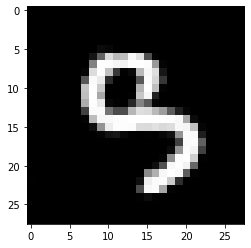

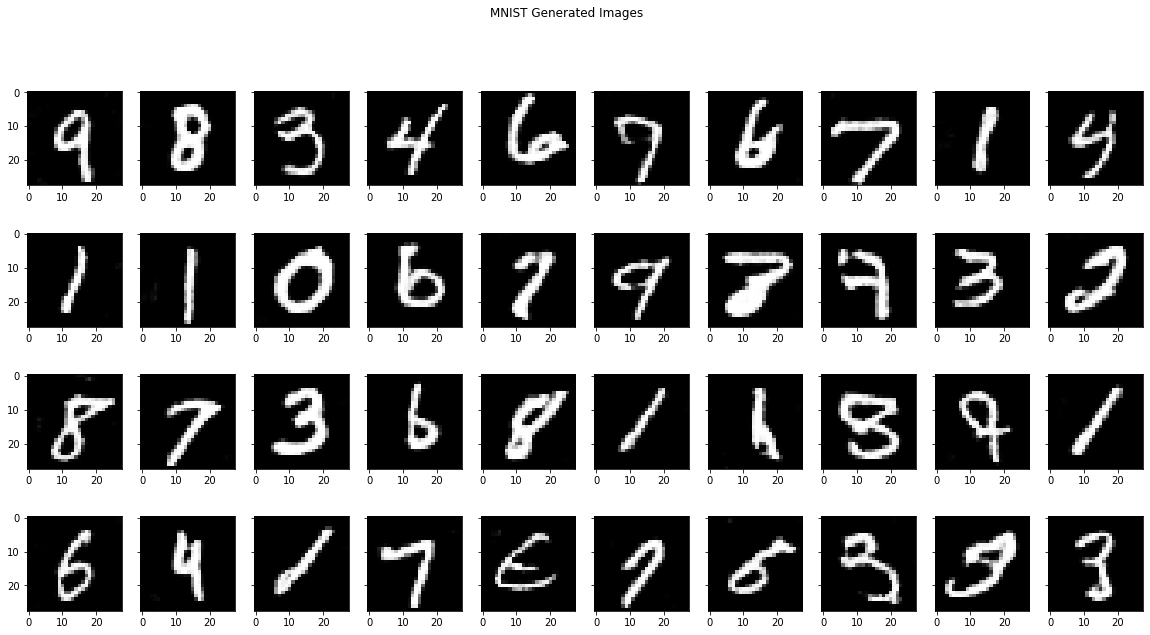

In [9]:
# Functions to save and load checkpoints

# Enter the path on your shared drive where the checkpoint is to be saved
## TODO ##
# For example path_to_checkpoint = '/content/drive/Shareddrives/CS763Lab8/'
path_to_checkpoint = './checkpoints'
## TODO ##


def save_checkpoint(e):
    if not os.path.isdir(path_to_checkpoint):
        os.mkdir(path_to_checkpoint)
    torch.save({'e': e, 'gen': G.state_dict(), 'disc': D.state_dict(), 'optim_d': optimizer_d.state_dict(
    ), 'optim_g': optimizer_g.state_dict()}, os.path.join(path_to_checkpoint, 'checkpoint_vanilla.pth'))


def load_checkpoint():
    if not os.path.isfile(os.path.join(path_to_checkpoint, 'checkpoint_vanilla.pth')):
        return -1
    dic = torch.load(os.path.join(
        path_to_checkpoint, 'checkpoint_vanilla.pth'))
    G.load_state_dict(dic['gen'])
    D.load_state_dict(dic['disc'])
    optimizer_d.load_state_dict(dic['optim_d'])
    optimizer_g.load_state_dict(dic['optim_g'])
    return dic['e']


# The generate functions are defined here
def generate(n):
    ## TODO ##
    fake_samples = G(torch.empty(n,100,1,1).normal_().to(device))
    return fake_samples.detach().cpu().numpy()
    ## TODO ##

## TODO ##
NUM_EPOCHS = 100
## TODO ##
losses_g = []
losses_d = []

# Resume training
offset = load_checkpoint()
if os.path.exists('images'):
    if offset == -1:
        os.system('rm -rf images')
        os.mkdir('images')
else:
    os.mkdir('images')


for e in range(NUM_EPOCHS):
    if e <= offset:
        continue
    loss, loss_g, loss_d = train(e)
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    G.eval()
    g_output = generate(1)[0]
    G.train()
    plt.imshow(g_output.reshape(28, 28), cmap='gray')
    plt.savefig('./images/{}.png'.format(e))
    print('loss_g = {}, loss_d = {}\n'.format(loss_g, loss_d))
    save_checkpoint(e)

# Test script
load_checkpoint()
with torch.no_grad():
    G.eval()
    fake_images = generate(40)
    fig, axs = plt.subplots(4, 10, sharey=True, figsize=(20, 10))
    for i in range(40):
        axs[i//10, i % 10].imshow(fake_images[i].reshape(28, 28), cmap='gray')
    plt.suptitle('MNIST Generated Images')
    plt.show()
